# Testing Graphical User Interfaces

In this chapter, we explore how to generate tests for Graphical User Interfaces (GUIs), abstracting from our [previous examples on Web testing](WebFuzzer.ipynb).  Building on general means to extract user interface elements and to activate them, our techniques generalize to arbitrary graphical user interfaces, from rich Web applications to mobile apps.

**Prerequisites**

* We build on the Web server introduced in the [chapter on Web testing](WebFuzzer.ipynb).

## Automated GUI Interaction

With our Web server: no JavaScript, no rich interfaces.  Also: Limited to Web.

How can we automate interaction?

### Our Web Server, Again

We (again) run our Web server.

In [1]:
import fuzzingbook_utils

In [2]:
from WebFuzzer import init_db, start_httpd, webbrowser, print_httpd_messages, print_url, ORDERS_DB

In [3]:
db = init_db()

In [4]:
httpd_process, httpd_url = start_httpd()
print_url(httpd_url)

In [5]:
from IPython.core.display import display, Image
from fuzzingbook_utils import HTML

In [6]:
HTML(webbrowser(httpd_url))

### Remote Control with Selenium

Let us just look at the GUI, above.  We do not assume we can access the HTML source, or even the URL of the current page.  All we assume is that there is a set of *user interface elements* we can interact with.

Documentation is available [here.](https://selenium-python.readthedocs.io/index.html)

In [7]:
from selenium import webdriver

In [8]:
from selenium.webdriver.firefox.options import Options

In [9]:
options = Options()
options.headless = True

In [10]:
from selenium.webdriver.firefox.firefox_profile import FirefoxProfile

In [11]:
ZOOM = 1.4
profile = FirefoxProfile()
profile.set_preference("layout.css.devPixelsPerPx", repr(ZOOM))

In [12]:
driver = webdriver.Firefox(firefox_profile=profile, options=options)

In [13]:
# Alternative: Chrome

# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# options.add_argument('window-size=700x230')
# driver = webdriver.Chrome(options=options)

In [14]:
def go_home(driver):
    driver.get(httpd_url)

In [15]:
go_home(driver)

In [16]:
print_httpd_messages()

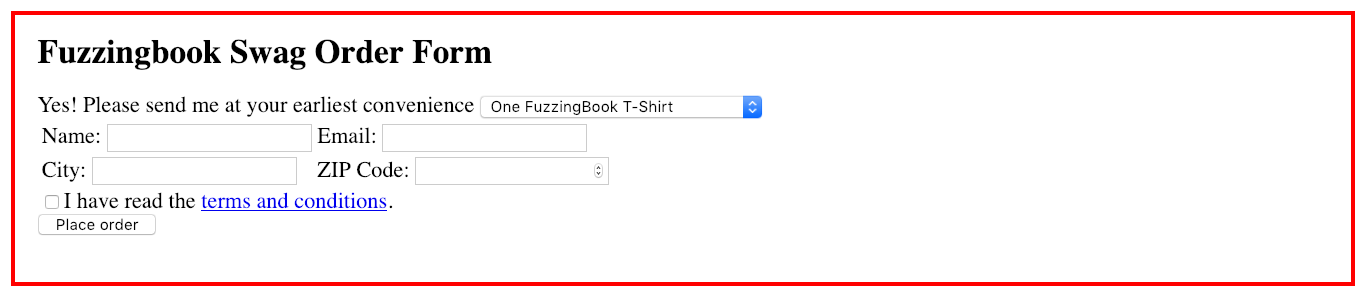

In [17]:
Image(driver.get_screenshot_as_png())

### Filling out Forms

In [18]:
name = driver.find_element_by_name("name")
name.send_keys("Jane Doe")

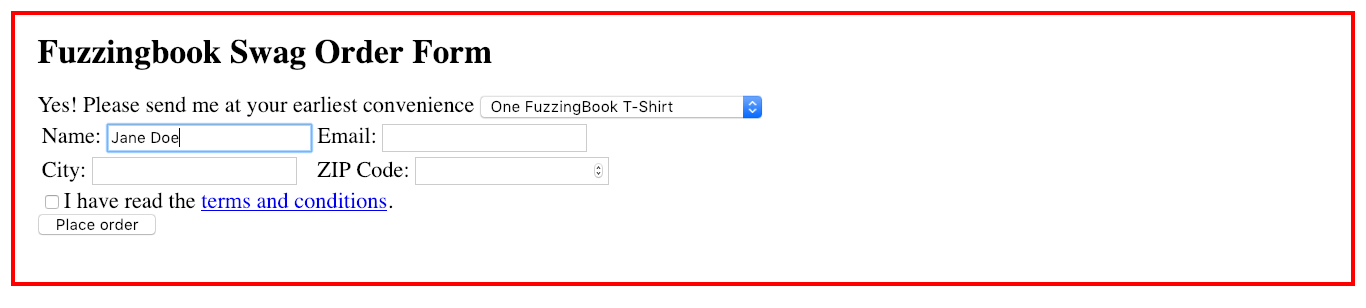

In [19]:
Image(driver.get_screenshot_as_png())

In [20]:
email = driver.find_element_by_name("email")
email.send_keys("j.doe@example.com")

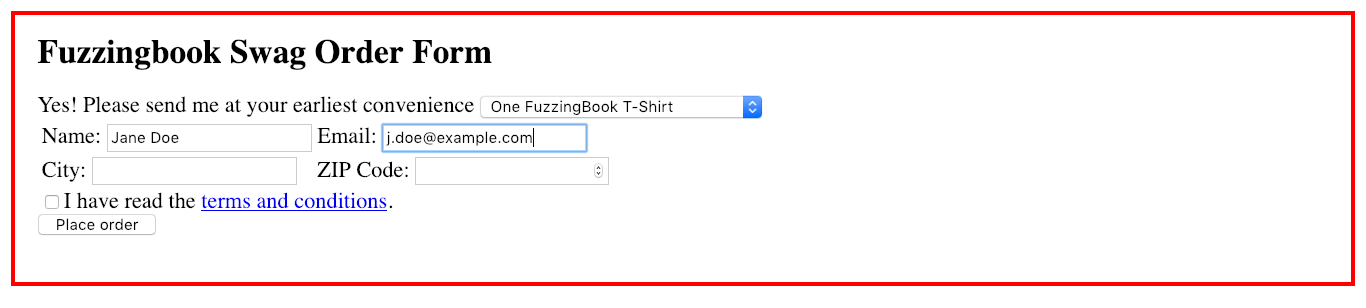

In [21]:
Image(driver.get_screenshot_as_png())

In [22]:
city = driver.find_element_by_name('city')
city.send_keys("Seattle")

In [23]:
zip = driver.find_element_by_name('zip')
zip.send_keys("98104")

In [24]:
terms = driver.find_element_by_name('terms')
terms.click()

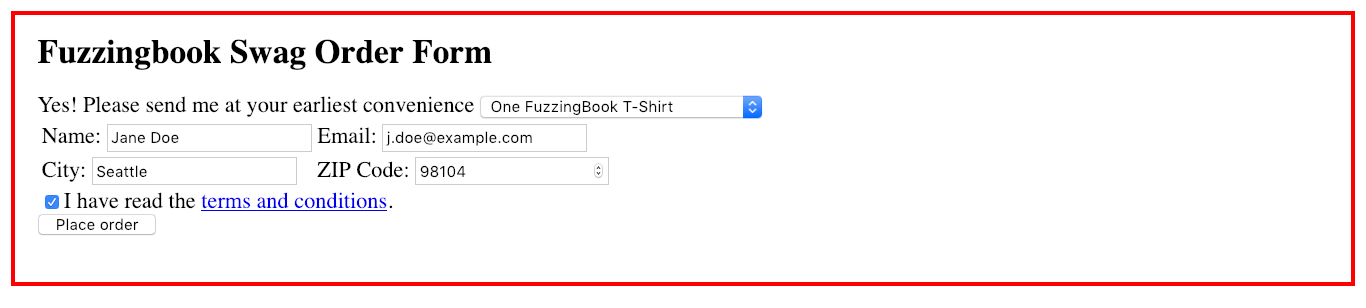

In [25]:
Image(driver.get_screenshot_as_png())

In [26]:
submit = driver.find_element_by_name('submit')
submit.click()

In [27]:
print_httpd_messages()

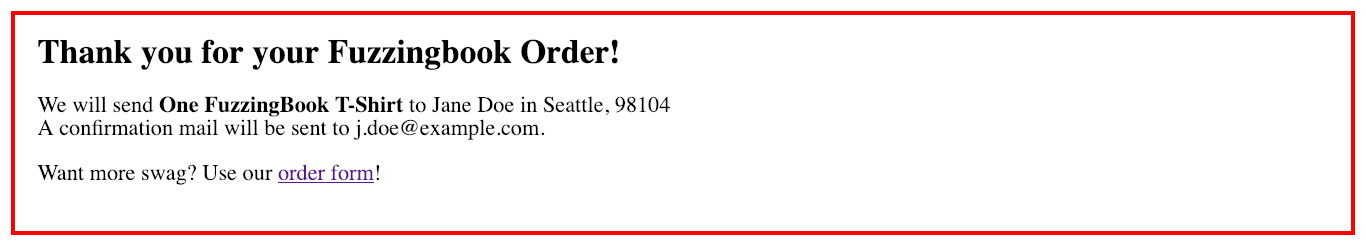

In [28]:
Image(driver.get_screenshot_as_png())

### Navigating

In [29]:
driver.back()

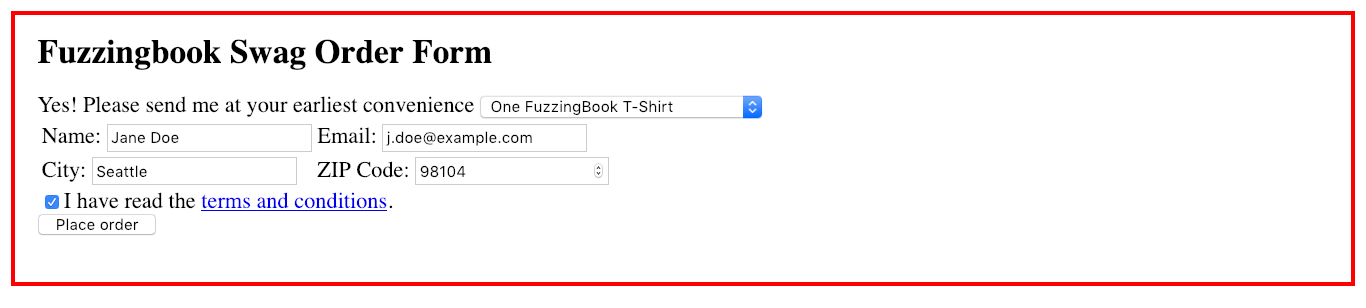

In [30]:
Image(driver.get_screenshot_as_png())

In [31]:
links = driver.find_elements_by_tag_name("a")

In [32]:
links[0].get_attribute('href')

'http://127.0.0.1:8802/terms'

In [33]:
links[0].click()

In [34]:
print_httpd_messages()

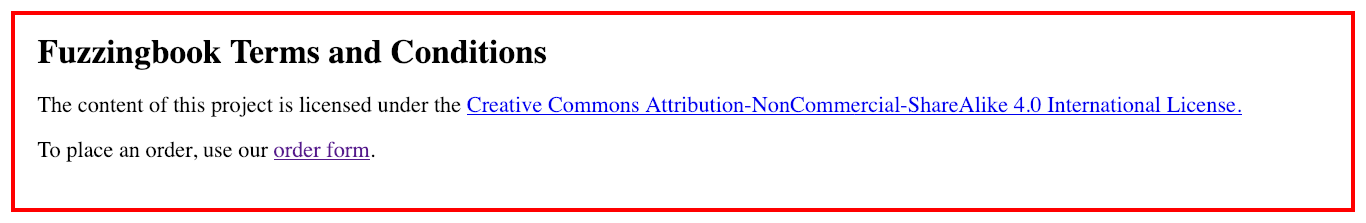

In [35]:
Image(driver.get_screenshot_as_png())

In [36]:
driver.back()

In [37]:
print_httpd_messages()

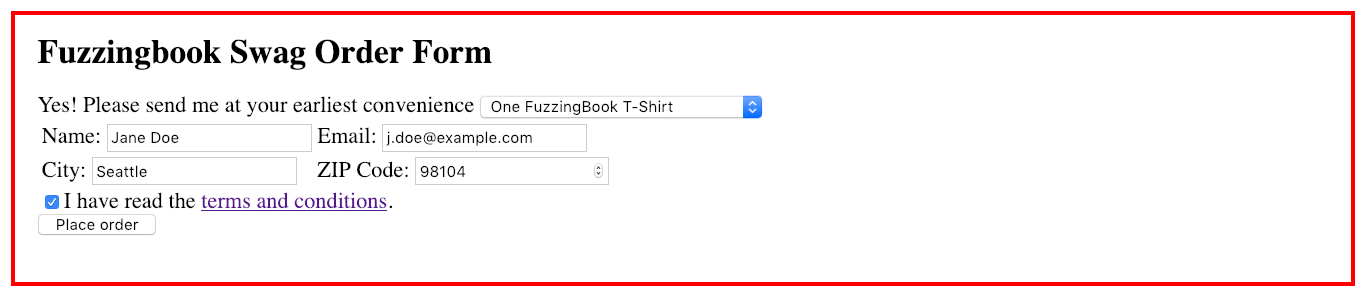

In [38]:
Image(driver.get_screenshot_as_png())

## Retrieving UI Elements

In [39]:
go_home(driver)

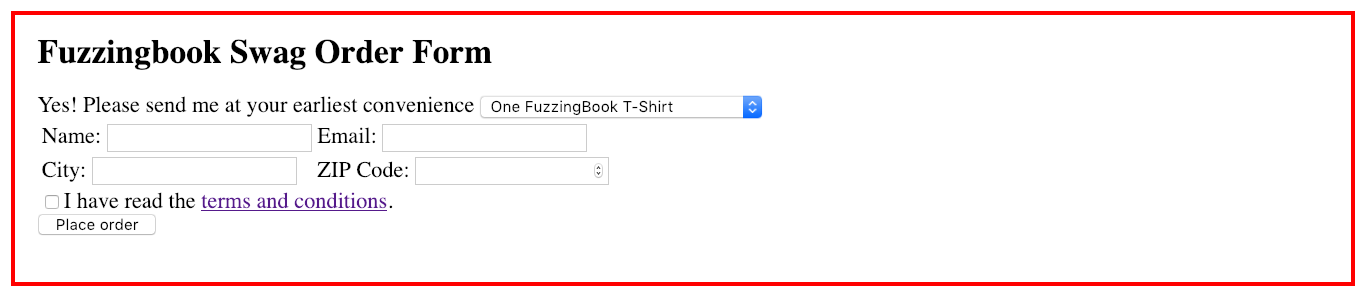

In [40]:
Image(driver.get_screenshot_as_png())

In [41]:
ui_elements = driver.find_elements_by_tag_name("input")

In [42]:
for element in ui_elements:
    print(element.get_attribute('name'), element.get_attribute('type'), element.text)

name text 
email email 
city text 
zip number 
terms checkbox 
submit submit 


In [43]:
ui_elements = driver.find_elements_by_tag_name("button")

In [44]:
for element in ui_elements:
    print(element.get_attribute('name'), element.get_attribute('type'), element.text)

In [45]:
class GUIGrammarMiner(object):
    def __init__(self, driver):
        self.driver = driver
        self.grammar = {}

In [46]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_state_actions(self):
        actions = set()
        
        for elem in driver.find_elements_by_tag_name("input"):
            input_type = elem.get_attribute("type")
            input_name = elem.get_attribute("name")
            if input_name is None:
                input_name = elem.text

            if input_type in ["button", "checkbox", "radio"]:
                actions.add("click(%s)" % repr(input_name))
            elif input_type in ["text", "number", "password"]:
                actions.add("fill(%s, <quoted-%s>)" % (repr(input_name), input_type))
            elif input_type in ["submit"]:
                actions.add("submit(%s)" % repr(input_name))
            else:
                # TODO: Handle more types here
                actions.add("fill(%s, <quoted-%s>)" % (repr(input_name), input_type))

        for elem in driver.find_elements_by_tag_name("button"):
            button_type = elem.get_attribute("type")
            button_name = elem.get_attribute("name")
            if button_name is None:
                button_name = elem.text
            if button_type == "submit":
                actions.add("submit(%s)" % repr(input_name))
            elif button_type != "reset":
                actions.add("click(%s)" % repr(input_name))

        for elem in driver.find_elements_by_tag_name("a"):
            a_href = elem.get_attribute("href")
            if a_href is not None:
                actions.add("click(%s)" % repr(elem.text))

        return frozenset(actions)

\todo{Checkboxes can be clicked (toggled), but act as form values}

In [47]:
gui_grammar_miner = GUIGrammarMiner(driver)
gui_grammar_miner.mine_state_actions()

frozenset({"click('terms and conditions')",
           "click('terms')",
           "fill('city', <quoted-text>)",
           "fill('email', <quoted-email>)",
           "fill('name', <quoted-text>)",
           "fill('zip', <quoted-number>)",
           "submit('submit')"})

This set of interactive elements makes up a _page_.

## Systematic GUI Exploration

### Representing States as Grammars

\todo{}: Have a generic interface `BaseGrammarMiner` with `__init__()` and `mine_grammar()`

In [48]:
from Grammars import new_symbol

In [49]:
from Grammars import nonterminals, START_SYMBOL
from Grammars import extend_grammar, unreachable_nonterminals, opts, crange, srange
from Grammars import syntax_diagram, is_valid_grammar

In [50]:
from WebFuzzer import HTMLGrammarMiner

In [51]:
class GUIGrammarMiner(GUIGrammarMiner):
    START_STATE = "<state>"
    FINAL_STATE = "<end>"
    UNEXPLORED_STATE = "<unexplored>"

    GUI_GRAMMAR = ({
        START_SYMBOL: [START_STATE],
        UNEXPLORED_STATE: [""],
        FINAL_STATE: [""],

        "<text>": ["<string>"],
        "<string>": ["<character>", "<string><character>"],
        "<character>": ["<letter>", "<digit>", "<special>"],
        "<letter>": crange('a', 'z') + crange('A', 'Z'),
        
        "<number>": ["<digits>"],
        "<digits>": ["<digit>", "<digits><digit>"],
        "<digit>": crange('0', '9'),
        
        "<special>": srange(". !"),

        "<email>": ["<letters>@<letters>"],
        "<letters>": ["<letter>", "<letters><letter>"],
        
        # Use a fixed password in case we need to repeat it
        "<password>": ["abcABC.123"],
        
        "<hidden>": "<string>",
    })

start


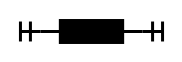

unexplored


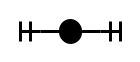

end


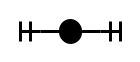

text


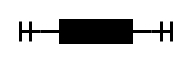

string


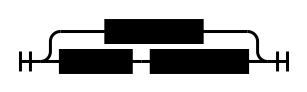

character


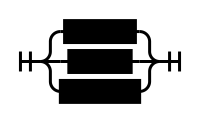

letter


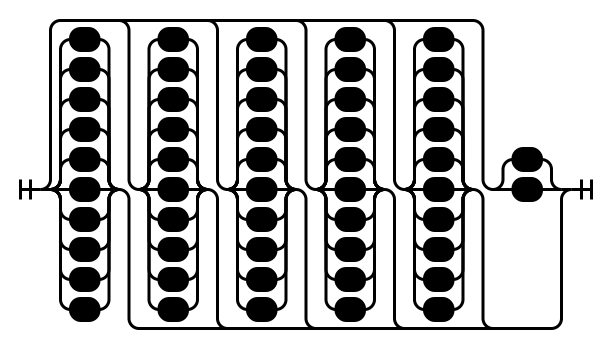

number


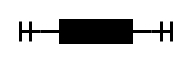

digits


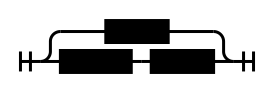

digit


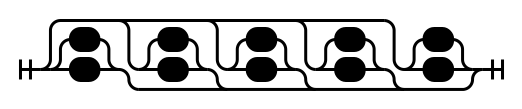

special


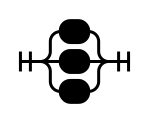

email


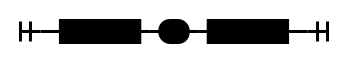

letters


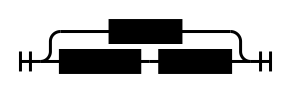

password


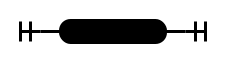

hidden


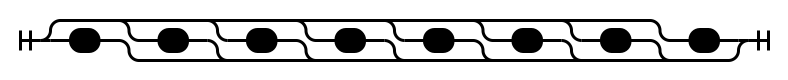

In [52]:
syntax_diagram(GUIGrammarMiner.GUI_GRAMMAR)

In [53]:
class GUIGrammarMiner(GUIGrammarMiner):
    for elem in ["text", "number", "email", "password", "hidden"]:
        GUIGrammarMiner.GUI_GRAMMAR["<quoted-%s>" % elem] = \
            [("<%s>" % elem, opts(post=repr))]

In [54]:
GUIGrammarMiner.GUI_GRAMMAR['<quoted-text>']

[('<text>', {'post': <function repr(obj, /)>})]

In [55]:
class GUIGrammarMiner(GUIGrammarMiner):
    def new_state_symbol(self, grammar):
        return new_symbol(grammar, self.START_STATE)

    def mine_state_grammar(self, grammar=None, state_symbol=None):
        if grammar is None:
            grammar = extend_grammar(self.GUI_GRAMMAR)
        else:
            grammar = extend_grammar(grammar)

        if state_symbol is None:
            state_symbol = self.new_state_symbol(grammar)
            grammar[state_symbol] = []

        alternatives = []
        form = ""
        submit = None

        for action in self.mine_state_actions():
            if action.startswith("submit"):
                submit = action
                
            elif action.startswith("click"):
                link_target = self.new_state_symbol(grammar)
                grammar[link_target] = [self.UNEXPLORED_STATE]
                alternatives.append(action + '\n' + link_target)

            elif action.startswith("fill"):
                if len(form) > 0:
                    form += '\n'
                form += action

        if submit is not None:
            if len(form) > 0:
                form += '\n'
            form += submit

        if len(form) > 0:
            form_target = self.new_state_symbol(grammar)
            grammar[form_target] = [self.UNEXPLORED_STATE]
            alternatives.append(form + '\n' + form_target)
            
        alternatives += [self.FINAL_STATE]

        grammar[state_symbol] = alternatives
        
        # Remove unused parts
        for nonterminal in unreachable_nonterminals(grammar):
            del grammar[nonterminal]

        assert is_valid_grammar(grammar)
        
        return grammar

In [56]:
gui_grammar_miner = GUIGrammarMiner(driver)
state_grammar = gui_grammar_miner.mine_state_grammar()
state_grammar

{'<start>': ['<state>'],
 '<unexplored>': [''],
 '<end>': [''],
 '<text>': ['<string>'],
 '<string>': ['<character>', '<string><character>'],
 '<character>': ['<letter>', '<digit>', '<special>'],
 '<letter>': ['a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'],
 '<number>': ['<digits>'],
 '<digits>': ['<digit>', '<digits><digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<special>': ['.', ' ', '!'],
 '<email>': ['<letters>@<letters>'],
 '<letters>': ['<letter>', '<letters><letter>'],
 '<quoted-text>': [('<text>', {'post': <function repr(obj, /)>})],
 '<quoted-number>': [('<number>', {'post': <function repr(obj, /)>})],
 '<quoted-email>': [('<email>', {'po

In [57]:
state_grammar[GUIGrammarMiner.START_STATE]

["click('terms')\n<state-1>",
 "click('terms and conditions')\n<state-2>",
 "fill('zip', <quoted-number>)\nfill('name', <quoted-text>)\nfill('city', <quoted-text>)\nfill('email', <quoted-email>)\nsubmit('submit')\n<state-3>",
 '<end>']

The grammar actually encodes a Finite State Machine:

In [58]:
from graphviz import Digraph
from IPython.display import display
from GrammarFuzzer import dot_escape
from collections import deque

In [59]:
def fsm_diagram(grammar, start_symbol=START_SYMBOL):
    dot = Digraph(comment="Grammar as Finite State Machine")

    symbols = deque([start_symbol])
    symbols_seen = set()
    
    while len(symbols) > 0:
        symbol = symbols.popleft()
        symbols_seen.add(symbol)
        dot.node(symbol, dot_escape(symbol))
        
        for expansion in grammar[symbol]:
            nts = nonterminals(expansion)
            if len(nts) > 0:
                target_symbol = nts[-1]
                if target_symbol not in symbols_seen:
                    symbols.append(target_symbol)

                label = expansion.replace(target_symbol, '')
                dot.edge(symbol, target_symbol, label.replace('\n', r'\l'))
                
    display(dot)

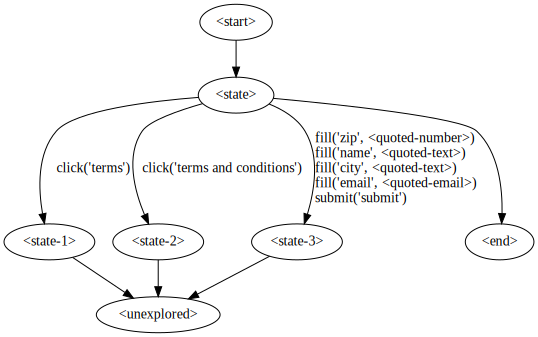

In [60]:
fsm_diagram(state_grammar)

In [61]:
# Remove unused parts
for nonterminal in unreachable_nonterminals(state_grammar):
    del state_grammar[nonterminal]

In [62]:
from GeneratorGrammarFuzzer import GeneratorGrammarFuzzer

In [63]:
gui_fuzzer = GeneratorGrammarFuzzer(state_grammar)
print(gui_fuzzer.fuzz())

click('terms')



### Fuzzing GUI Forms

In [64]:
from Fuzzer import Runner

In [65]:
class GUIRunner(Runner):
    def __init__(self, driver):
        self.driver = driver
        
    def run(self, inp):
        def click(name):
            self.do_click(name)
        def fill(name, value):
            self.do_fill(name, value)
        def submit(name):
            self.do_submit(name)
        
        exec(inp, {}, {'click': click, 'submit': submit, 'fill': fill})
        
        return inp, self.PASS

In [66]:
from selenium.common.exceptions import NoSuchElementException

In [67]:
class GUIRunner(GUIRunner):
    def find_element(self, name):
        try:
            return self.driver.find_element_by_name(name)
        except NoSuchElementException:
            return self.driver.find_element_by_link_text(name)

We need delays (in seconds):

In [68]:
from selenium.webdriver.support.ui import WebDriverWait

In [69]:
class GUIRunner(GUIRunner):
    DELAY_AFTER_CLICK = 1
    DELAY_AFTER_SUBMIT = 1
    DELAY_AFTER_FILL = 0.1

In [70]:
class GUIRunner(GUIRunner):
    def do_click(self, name):
        element = self.find_element(name)
        element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_CLICK)

In [71]:
class GUIRunner(GUIRunner):
    def do_submit(self, name):
        element = self.find_element(name)
        element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_SUBMIT)

In [72]:
class GUIRunner(GUIRunner):
    def do_fill(self, name, value):
        element = self.find_element(name)
        element.send_keys(value)
        WebDriverWait(self.driver, self.DELAY_AFTER_FILL)

In [73]:
go_home(driver)

In [74]:
gui_runner = GUIRunner(driver)

In [75]:
gui_runner.run("fill('name', 'Walter White')")

("fill('name', 'Walter White')", 'PASS')

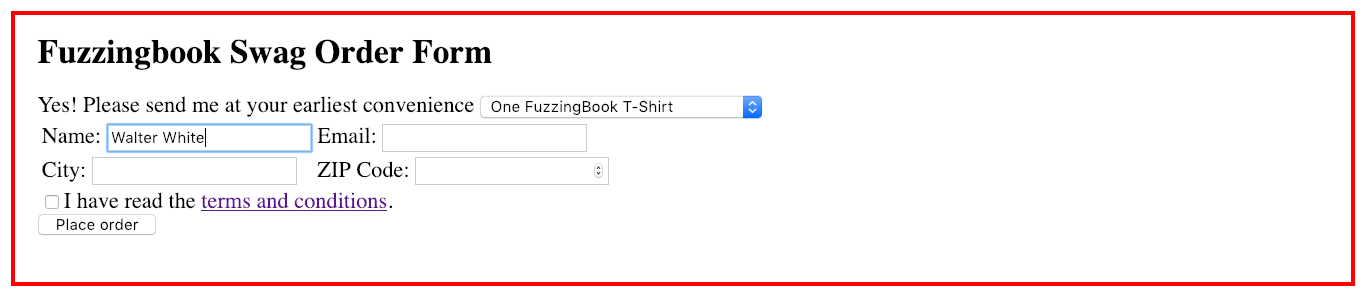

In [76]:
Image(driver.get_screenshot_as_png())

In [77]:
gui_runner.run("submit('submit')")

("submit('submit')", 'PASS')

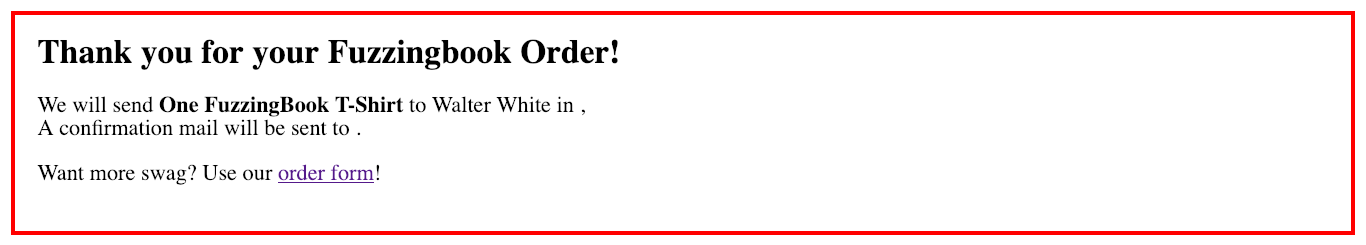

In [78]:
Image(driver.get_screenshot_as_png())

In [79]:
go_home(driver)

In [80]:
gui_fuzzer = GeneratorGrammarFuzzer(state_grammar)

In [81]:
while True:
    action = gui_fuzzer.fuzz()
    if action.find('submit(') > 0:
        break

In [82]:
print(action)

fill('zip', '0201')
fill('name', '1')
fill('city', 't')
fill('email', 'KW@d')
submit('submit')



In [83]:
gui_runner.run(action)

("fill('zip', '0201')\nfill('name', '1')\nfill('city', 't')\nfill('email', 'KW@d')\nsubmit('submit')\n",
 'PASS')

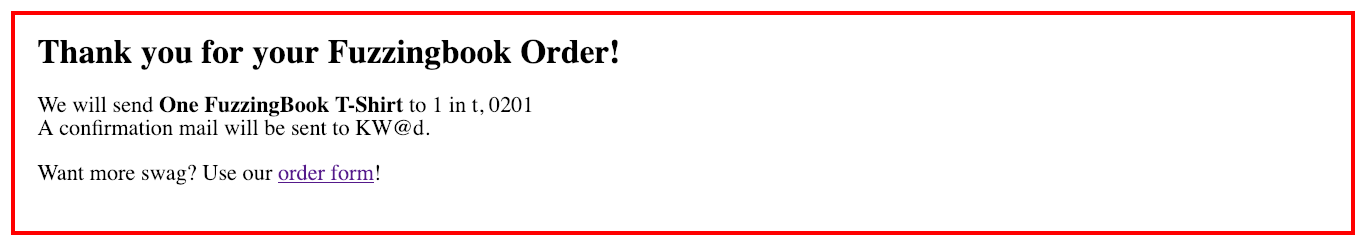

In [84]:
Image(driver.get_screenshot_as_png())

### Exploring States

In [85]:
import time

In [86]:
from Grammars import is_nonterminal

In [87]:
from GeneratorGrammarFuzzer import ProbabilisticGeneratorGrammarCoverageFuzzer as PGGCFuzzer

In [88]:
class GUIFuzzer(PGGCFuzzer):
    def __init__(self, driver, restart=None, **kwargs):
        self.driver = driver
        self.miner = GUIGrammarMiner(driver)
        self.restart_function = restart

        self.states_seen = {}  # Maps states to symbols
        self.state_symbol = GUIGrammarMiner.START_STATE
        self.state = self.miner.mine_state_actions()
        self.states_seen[self.state] = self.state_symbol
        
        grammar = self.miner.mine_state_grammar()
        super().__init__(grammar, **kwargs)

In [89]:
class GUIFuzzer(GUIFuzzer):
    def restart(self):
        if self.restart_function is not None:
            self.restart_function(driver)
        else:
            # Generic back to start
            for i in range(20):
                self.driver.back()

        self.state = GUIGrammarMiner.START_STATE

In [90]:
class GUIFuzzer(GUIFuzzer):
    def fsm_path(self, tree):
        """Return sequence of state symbols"""
        (node, children) = tree
        if node == GUIGrammarMiner.UNEXPLORED_STATE:
            return []
        elif children is None or len(children) == 0:
            return [node]
        else:
            return [node] + self.fsm_path(children[-1])

In [91]:
class GUIFuzzer(GUIFuzzer):
    def fsm_last_state_symbol(self, tree):
        """Return current (expected) state symbol"""
        for state in reversed(self.fsm_path(tree)):
            if is_nonterminal(state):
                return state
        assert False

In [92]:
class GUIFuzzer(GUIFuzzer):
    def run(self, gui_runner):
        assert isinstance(gui_runner, GUIRunner)
        
        self.restart()
        action = self.fuzz()
        self.state_symbol = self.fsm_last_state_symbol(self.derivation_tree)

        # print(action, self.state_symbol)
        
        result, outcome = gui_runner.run(action)
        self.update_state()

        return self.state_symbol, outcome

In [93]:
class GUIFuzzer(GUIFuzzer):
    def update_state(self):
        self.state = self.miner.mine_state_actions()
        if self.state not in self.states_seen:
            self.states_seen[self.state] = self.state_symbol
            self.update_new_state()
        else:
            self.update_existing_state()

In [94]:
class GUIFuzzer(GUIFuzzer):            
    def update_new_state(self):
        print("Found new state", self.state_symbol, self.state)

        state_grammar = self.miner.mine_state_grammar(grammar=self.grammar, 
                                                      state_symbol=self.state_symbol)
        del state_grammar[START_SYMBOL]
        del state_grammar[GUIGrammarMiner.START_STATE]
        new_grammar = extend_grammar(self.grammar, state_grammar)

        self.grammar = new_grammar  # FIXME: Should be set_grammar or likewise

In [95]:
from Grammars import exp_string, exp_opts

In [96]:
def replace_symbol(grammar, old_symbol, new_symbol):
    """Return a grammar in which all occurrences of `old_symbol` are replaced by `new_symbol`"""
    new_grammar = {}
    
    for symbol in grammar:
        new_expansions = []
        for expansion in grammar[symbol]:
            new_expansion_string = exp_string(expansion).replace(old_symbol, new_symbol)
            if len(exp_opts(expansion)) > 0:
                new_expansion = (new_expansion_string, exp_opts(expansion))
            else:
                new_expansion = new_expansion_string
            new_expansions.append(new_expansion)
                
        new_grammar[symbol] = new_expansions
        
    # Remove unused parts
    for nonterminal in unreachable_nonterminals(new_grammar):
        del new_grammar[nonterminal]

    return new_grammar

In [97]:
class GUIFuzzer(GUIFuzzer):            
    def update_existing_state(self):
        print("In existing state", self.states_seen[self.state])
        
        if self.state_symbol != self.states_seen[self.state]:
            print("Expected state", self.state_symbol)
            
            # FIXME: Should be set_grammar or likewise
            self.grammar = replace_symbol(self.grammar, self.state_symbol, self.states_seen[self.state])
            self.state_symbol = self.states_seen[self.state]

In [98]:
go_home(driver)

In [99]:
gui_fuzzer = GUIFuzzer(driver, restart=go_home)

In [100]:
gui_fuzzer.fuzz()

"click('terms and conditions')\n"

In [101]:
from GrammarFuzzer import display_tree

In [102]:
gui_fuzzer.run(gui_runner)

In existing state <state>
Expected state <state-1>


('<state>', 'PASS')

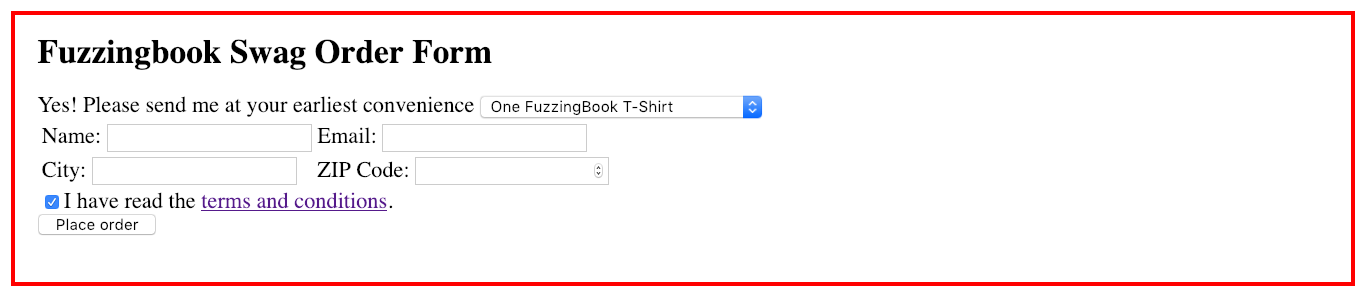

In [103]:
Image(driver.get_screenshot_as_png())

In [104]:
gui_fuzzer.restart()

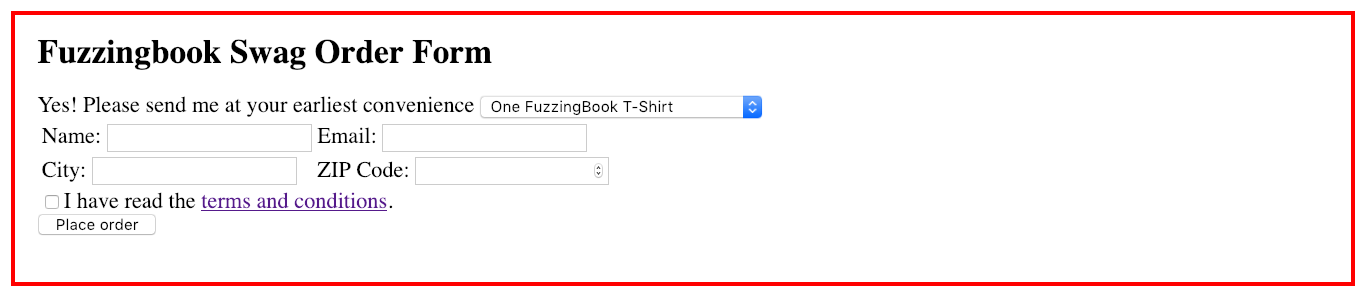

In [105]:
Image(driver.get_screenshot_as_png())

In [106]:
gui_fuzzer.grammar

{'<start>': ['<state>'],
 '<unexplored>': [''],
 '<end>': [''],
 '<text>': ['<string>'],
 '<string>': ['<character>', '<string><character>'],
 '<character>': ['<letter>', '<digit>', '<special>'],
 '<letter>': ['a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'],
 '<number>': ['<digits>'],
 '<digits>': ['<digit>', '<digits><digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<special>': ['.', ' ', '!'],
 '<email>': ['<letters>@<letters>'],
 '<letters>': ['<letter>', '<letters><letter>'],
 '<quoted-text>': [('<text>', {'post': <function repr(obj, /)>})],
 '<quoted-number>': [('<number>', {'post': <function repr(obj, /)>})],
 '<quoted-email>': [('<email>', {'po

In [107]:
fsm_diagram(gui_fuzzer.grammar)

\todo{Consider an alternate encoding that does not need a generator}

In [108]:
IF_ONLY_THIS_WOULD_WORK = False

In [109]:
if IF_ONLY_THIS_WOULD_WORK:
    for i in range(20):
        print("Run", i)
        gui_fuzzer.run(gui_runner)
        print()

\todo{When finding that a "new" state is a "known" state, change the grammar accordingly}

In [110]:
gui_fuzzer.grammar

{'<start>': ['<state>'],
 '<unexplored>': [''],
 '<end>': [''],
 '<text>': ['<string>'],
 '<string>': ['<character>', '<string><character>'],
 '<character>': ['<letter>', '<digit>', '<special>'],
 '<letter>': ['a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'],
 '<number>': ['<digits>'],
 '<digits>': ['<digit>', '<digits><digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<special>': ['.', ' ', '!'],
 '<email>': ['<letters>@<letters>'],
 '<letters>': ['<letter>', '<letters><letter>'],
 '<quoted-text>': [('<text>', {'post': <function repr(obj, /)>})],
 '<quoted-number>': [('<number>', {'post': <function repr(obj, /)>})],
 '<quoted-email>': [('<email>', {'po

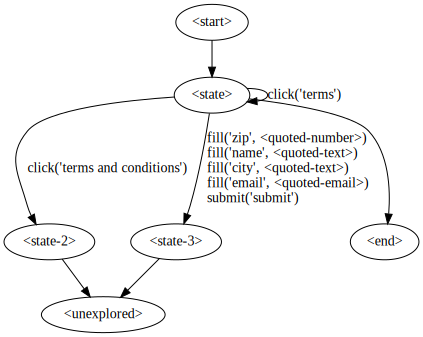

In [111]:
fsm_diagram(gui_fuzzer.grammar)

In [112]:
gui_fuzzer.missing_expansion_coverage()

{'<character> -> <digit>',
 '<character> -> <letter>',
 '<character> -> <special>',
 '<digit> -> 0',
 '<digit> -> 1',
 '<digit> -> 2',
 '<digit> -> 3',
 '<digit> -> 4',
 '<digit> -> 5',
 '<digit> -> 6',
 '<digit> -> 7',
 '<digit> -> 8',
 '<digit> -> 9',
 '<digits> -> <digit>',
 '<digits> -> <digits><digit>',
 '<email> -> <letters>@<letters>',
 '<end> -> ',
 '<letter> -> A',
 '<letter> -> B',
 '<letter> -> C',
 '<letter> -> D',
 '<letter> -> E',
 '<letter> -> F',
 '<letter> -> G',
 '<letter> -> H',
 '<letter> -> I',
 '<letter> -> J',
 '<letter> -> K',
 '<letter> -> L',
 '<letter> -> M',
 '<letter> -> N',
 '<letter> -> O',
 '<letter> -> P',
 '<letter> -> Q',
 '<letter> -> R',
 '<letter> -> S',
 '<letter> -> T',
 '<letter> -> U',
 '<letter> -> V',
 '<letter> -> W',
 '<letter> -> X',
 '<letter> -> Y',
 '<letter> -> Z',
 '<letter> -> a',
 '<letter> -> b',
 '<letter> -> c',
 '<letter> -> d',
 '<letter> -> e',
 '<letter> -> f',
 '<letter> -> g',
 '<letter> -> h',
 '<letter> -> i',
 '<letter> 

### Optimizations

\todo{Special challenge: We need to go back to get to earlier state.}

What is in unknown?

## Fun with FuzzingBook

\todo{Create a full map of fuzzingbook.org, only by navigating}

In [113]:
driver.get("https://www.fuzzingbook.org/")

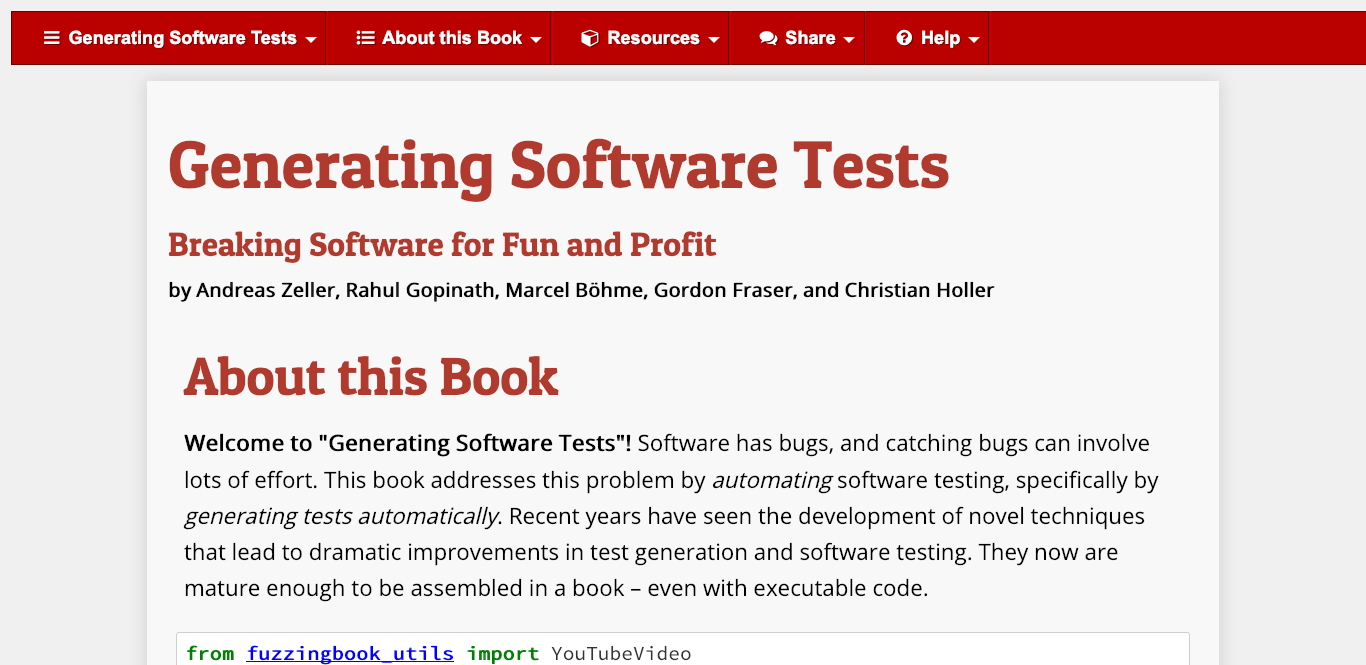

In [114]:
Image(driver.get_screenshot_as_png())

In [115]:
pass
# links = driver.find_elements_by_tag_name("a")
# for link in links:
#     print(link.tag_name, link.text, link.get_attribute("href"))

That's it – we're done!

In [116]:
driver.quit()

In [117]:
httpd_process.terminate()

In [118]:
import os

In [119]:
for temp_file in [ORDERS_DB, "geckodriver.log", "ghostdriver.log"]:
    if os.path.exists(temp_file):
        os.remove(temp_file)

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [120]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [121]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_